In [446]:
import pandas as pd

df = pd.read_csv("harjoitustyondata.csv", sep=";")
# Turning time into a datetime object
df['Aika'] = pd.to_datetime(df['Aika'], format='%d.%m.%Y %H:%M')
# print(df)

# Getting information about students
students = df.Pisteet.unique()
print(len(students), min(students), max(students))
course_start = df['Aika'].min()
course_end = df['Aika'].max()
print(course_start, course_end)

# To make things easier, let's collect the students into a dictionary, 
# where the points are the key to a list of all the student's timestamps
student_dict = {}
for student in students:
    # This gives us a dataframe 
    student_info = df.loc[df['Pisteet'] == student]
    timestamp_list = student_info['Aika'].tolist()
    student_dict[student] = timestamp_list

score_student_mapping = {score: f"{idx+1}" for idx, score in enumerate(df['Pisteet'].unique())}
df['student_id'] = df['Pisteet'].map(score_student_mapping)

150 1055 7594
2019-08-07 10:15:00 2020-01-29 14:11:00


Above we are sorting the data. The data is first turned into a Pandas DataFrame.
In the dataset, we have 150 different students, whose score range from 1055 points to 7594 points.
The first entry was 7.8.2019 and the last 29.1.2020, so we are assuming this is the duration of the course. 
This would mean that the course was active for about 6 months. 

_We should probably analyze the data a bit more to get more information about the course and how to build the model._

Let's see how long each students took to complete (or give up on) the course.
    - plotting on the x-axis the amount of time used (in days)
    - the course points are in the y-axis

(To make this easier, the student data was turned into a dictionary, where student points are the keys, with 
the timestamps in a list as value.)

Below we can see that the point distribution is a bit unusual. Most of the students collected very high points.



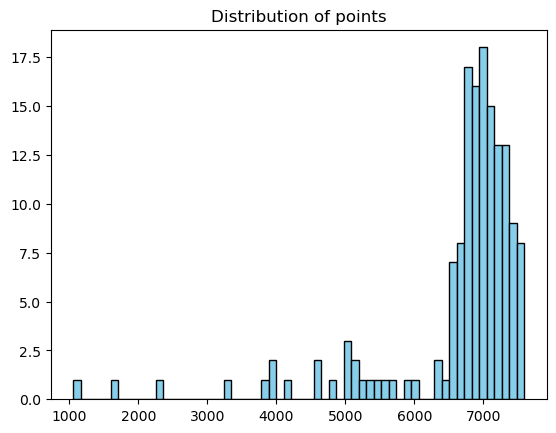

In [449]:
plt.hist(students, bins=60, color='skyblue', edgecolor='black')
plt.title('Distribution of points')
plt.show()

In [421]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data
# The time each student took to complete the course, rounded down
times = [(max(student_dict[s]) - min(student_dict[s])).total_seconds() / (60*60*24) + 1 for s in students]

# The number of different timestamps, i.e. the number of logs in total done by the student
logs = [len(student_dict[s]) for s in students]

# Finding out on how many different days a student worked on the course
dates = []
all_working_hours = [] #  time of day student tends to work, morning/day/night
pref_work_time = [] # 0 = morning, 1 = day, 2 = night
for s in students:  
    # Taking just the dates from timestamps, 
    # turning them into strings and to get only the unique values, turn the list into set
    uniq_dates = set([ str(d.date()) for d in student_dict[s]])
    # Append it as a list, 
    dates.append(len(uniq_dates)) 
    
    # Take the hour of the timesstamps and log it (morning: 6-12, day: 12-19, night: rest of the time)
    morning, day, night = 0, 0, 0
    hours = [(d.time().hour) for d in student_dict[s]]
    for hour in hours:
        if hour >= 6 and hour < 12:
            morning = morning + 1
        elif hour >= 12 and hour < 19:
            day = day + 1
        else: 
            night = night + 1
    # Here just collecting the data
    l = [morning, day, night]
    all_working_hours.append(l)
    # Finding out which index is the biggest to find out when student works the most
    # This is very inelegant, could be done better but let's see if there's something to it.
    m = max(l)
    pref_work_time.append(l.index(m))



In [367]:
# Here's a new dataframe for seaborn plotting.
# logs means the amount of logs,
# comp_t means the difference between last and first log, i.e. the course completion time
# log_days is the amount of days that logging has been done
# pref_work_t is the time of the day (morning, day, night) student has most time stamp logs
data = {"score": students, "logs": logs, "comp_t": times, "log_days":dates, "pref_work_t": pref_work_time }
df_new = pd.DataFrame(data)

# Hypothesis
- more active days --> better grade
- more logs --> better grade
- being consistently active --> better grade
- maybe the time of day spent working on the course has an effect on grades

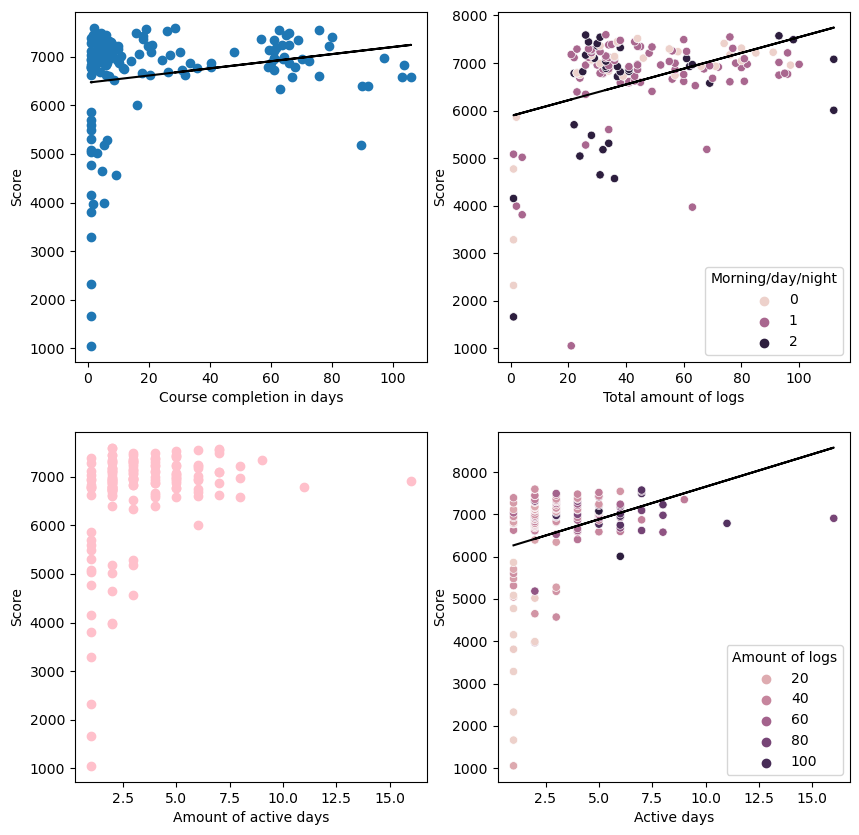

In [452]:
# Actual plotting 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

times_arr = np.array(times) # course completion time
logs_arr = np.array(logs) # amount of logs
students_arr = np.array(students) # scores
dates_arr = np.array(dates) # active days

# for regression models
time_slope, time_intercept = np.polyfit(times_arr, students_arr, 1)
logs_slope, logs_intercept = np.polyfit(logs_arr, students_arr, 1)
dates_slope, dates_intercept = np.polyfit(dates_arr, students_arr, 1)

ax1.plot(times, students, 'o')
ax1.set_xlabel('Course completion in days')
ax1.set_ylabel('Score')

sns.scatterplot(x="logs",
                    y="score",
                    hue="pref_work_t",
                    ax=ax2,
                    data=df_new)
ax2.set_ylabel('Score')
ax2.set_xlabel('Total amount of logs')
ax2.legend(title='Morning/day/night')

ax3.plot(dates_arr, students, 'o', color="pink")
ax3.set_xlabel('Amount of active days')
ax3.set_ylabel('Score')

# This is shit, ignore it :D
sns.scatterplot(x=dates_arr,
                    y="score",
                    hue="logs",
                    ax=ax4,
                    data=df_new)
                    #, palette="Blues")
ax4.set_xlabel('Active days')
ax4.set_ylabel('Score')
ax4.legend(title='Amount of logs')

ax1.plot(times_arr, time_slope * times_arr + time_intercept, color='black')
ax2.plot(logs_arr, logs_slope * logs_arr + logs_intercept, color='black')
ax4.plot(dates_arr, dates_slope * dates_arr + dates_intercept, color='black')

plt.show()

Above on the top left we can see that most of the students got very high points, a lot of them in a relatively short time interval.

On the top right, we can see that the amount of logs can vary a lot for the grade. More logs does not necessarily equal better grade. There is a slight upwards trajectory in the linear regression fitting, but not as distinct as one might expect. There is distinctin by color, 0 means students logs were mostly mornings, 1 means during daytime and 0 means during night. There seems to be a lot of morning workers who get good grades.

Bottom left we can see that almost all of the students completed the course with less than 10 days activity logged. If you put in more work, you will likely get a good score. 


_Is this gonna be good enough for classification? It can be seen, that if you put in more work, you will get a good grade. Though you can still get a good grade if you don't put in that much work, wtf._

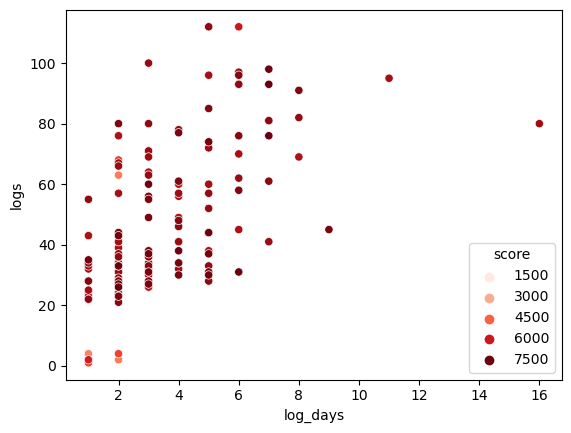

In [337]:
import seaborn as sns


sns.scatterplot(x="log_days",
                    y="logs",
                    hue="score",
                    data=df_new, palette='Reds')
plt.show()

Above we can kinda see a trend: multiple logs over multiple days seems to give a good grade. There is still quite a bit of clustering downish and left, I don't really know what to make of that :/

In [439]:
df

,Aika,Pisteet,student_id
0,2019-08-07 14:56:00,1055,1
1,2019-08-07 14:56:00,1055,1
2,2019-08-07 14:56:00,1055,1
3,2019-08-07 14:54:00,1055,1
4,2019-08-07 14:54:00,1055,1
...,...,...,...
6784,2019-10-14 12:48:00,7594,150
6785,2019-10-14 12:44:00,7594,150
6786,2019-10-14 12:44:00,7594,150
6787,2019-10-14 12:44:00,7594,150


Now, let's extract for each student ID: the score, the number of clicks that I have for each student and put all in a new dataset

In [450]:
student_stats = df.groupby('student_id').agg(
    n_recordings=('Aika', 'count'),
    score=('Pisteet', 'first')
    ).reset_index()

student_stats = student_stats.rename(columns={'student_id': 'student_id', 'n_recordings': 'num_recordings', 'score': 'score'})

print(student_stats)

    student_id  num_recordings  score
0            1              21   1055
1           10              31   4649
2          100              46   7103
3          101              33   7110
4          102              22   7113
..         ...             ...    ...
145         95              28   7070
146         96             112   7078
147         97              61   7094
148         98              81   7090
149         99              29   7100

[150 rows x 3 columns]


We can define the classes for the score, chosen in a way that each class has a relevant number of entries.

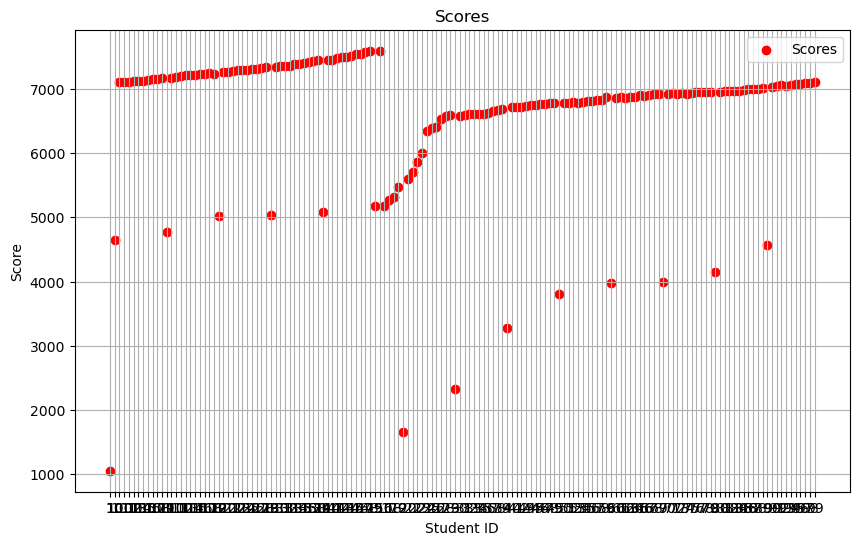

In [442]:
plt.figure(figsize=(10, 6))

plt.scatter(student_stats['student_id'], student_stats['score'], color='red', label='Scores')

plt.title('Scores')
plt.xlabel('Student ID')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


We can divide the scores in 3 categories:

* score < 6500
* 6500 < score < 7000
* score > 7000

In [443]:
print(student_stats[student_stats['score'] < 6500]['student_id'].nunique())
print(student_stats[(student_stats['score'] >= 6500) & (student_stats['score'] <= 7000)]['student_id'].nunique())
print(student_stats[student_stats['score'] > 7000]['student_id'].nunique())

26
62
62


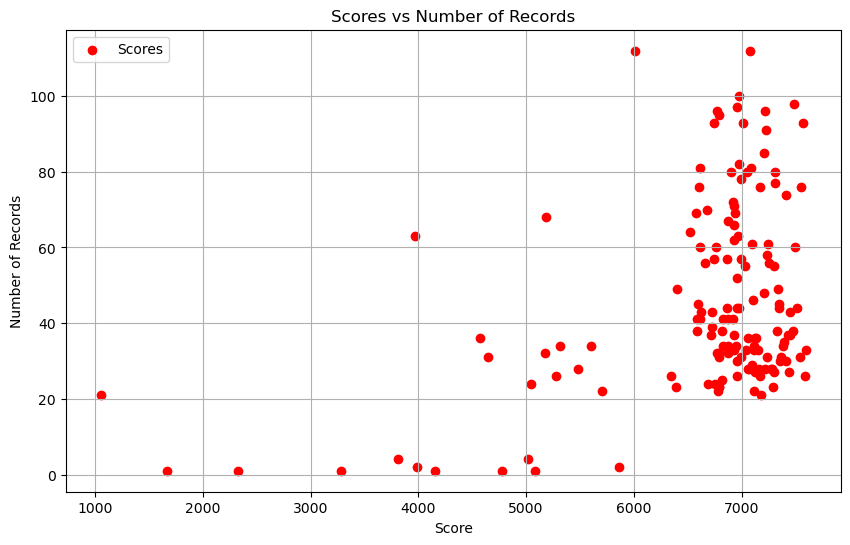

In [444]:
plt.figure(figsize=(10, 6))

plt.scatter(student_stats['score'], student_stats['num_recordings'], color='red', label='Scores')

plt.title('Scores vs Number of Records')
plt.xlabel('Score')
plt.ylabel('Number of Records')
plt.legend()
plt.grid(True)
plt.show()

Now, we want to predict the score class based on the number of clicks and the mean click time. In a decision tree, each node tells to which sub tree the input sample should move until the sub tree is only the leaf node that corresponds to some class.